<font size = "5"> **[Image Tools](../3_Image_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


# Adaptive Fourier Filtering


[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Imaging/I1_Adaptive_Fourier_Filter.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Imaging/I1_Adaptive_Fourier_Filter.ipynb)
    
    

part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


## Content
An introduction into Fourier Filtering of images.


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](../0_pyTEMlib.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.3.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')


installing pyTEMlib
done


## Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datasets. 



In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt 
import sys
import scipy

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../../')

%load_ext autoreload
%autoreload 2
import pyTEMlib


if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    
print('pyTEMlib version: ', pyTEMlib.__version__)
note_book_version = '2025.05.19'
note_book_name='pyTEMib/notebooks/Imaging/Adaptive_Fourier_Filter'

pyTEMlib version:  0.2026.1.0


## Open File

The data are held in the memory in the **sidpy** format with rather extensive capabilities.

All results can be stored in that **NSID** format file. 

First we select the file and the dataset (the dropdown menu at the bottom), in case there are several.

In [3]:
fileWidget = pyTEMlib.file_tools.FileWidget()

Now, we open and plot the selected dataset. Select another one and rerun only cell below (Home button gets you back to original).
>
> Please note that you can zoom and drag the intensity values in the color-bar.
>

dict_keys(['Channel_000'])

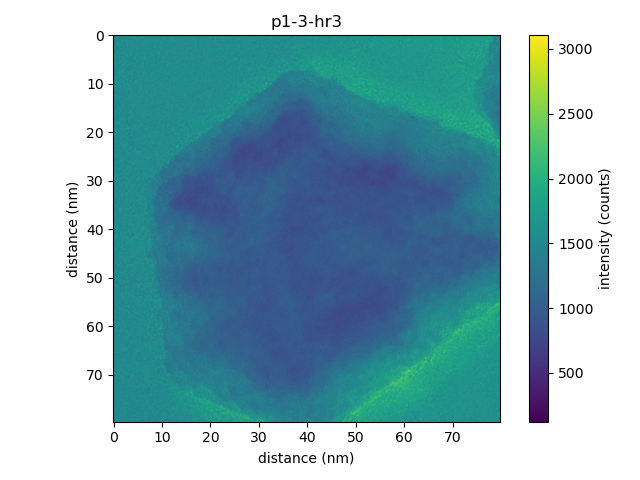

In [4]:
datasets = fileWidget.datasets
dataset = fileWidget.selected_dataset

if dataset.data_type.name != 'IMAGE':
    print('We really would need an image here')

view = dataset.plot()
datasets.keys()

## Power Spectrum of Image

fft :
	smoothing : 1
	minimum_intensity : 10.122878251923055
	maximum_intensity : 17.86281328568153
source:  p1-3-hr3


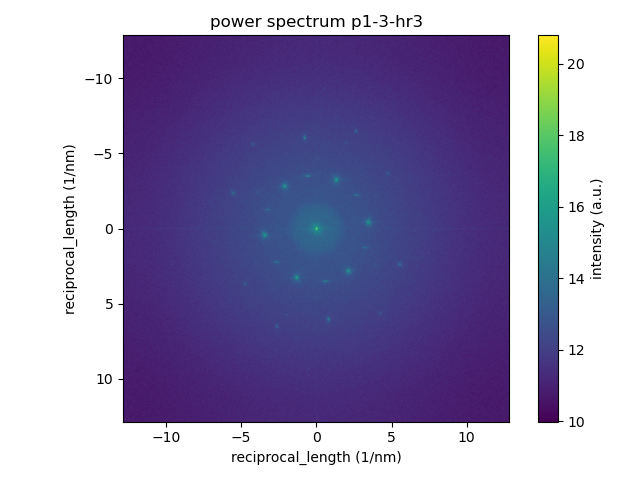

In [6]:
if dataset.data_type.name == 'IMAGE_STACK':
  stack_dim = dataset.get_dimensions_by_type('TEMPORAL')
  image = dataset.sum(axis=stack_dim)
  image.data_type = 'Image'
elif dataset.data_type.name == 'IMAGE':
  image = dataset
else:
  print('We really would need an image here')

power_spectrum = pyTEMlib.image_tools.power_spectrum(image, smoothing=1)
power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = power_spectrum.plot()

## Spot Detection in Fourier Transform

Change the spot_threshold value slightly up or down (down is more spots)

found 22


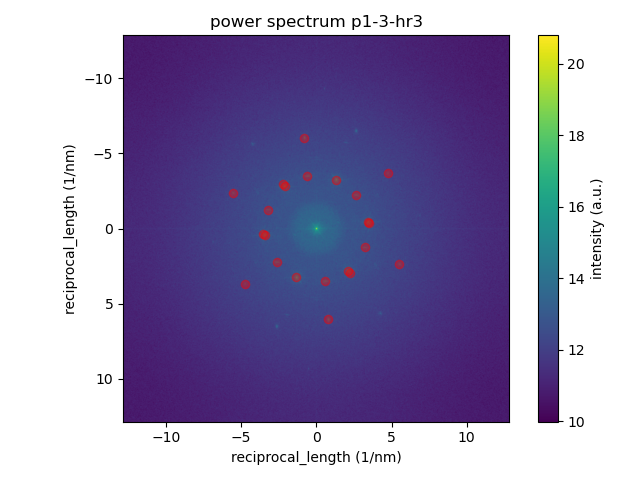

In [13]:
# ------Input----------
spot_threshold=0.05
# ---------------------

spots, _ = pyTEMlib.image_tools.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<7,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);
print(f"found {len(spots)}")

## Adaptive Fourier Filter

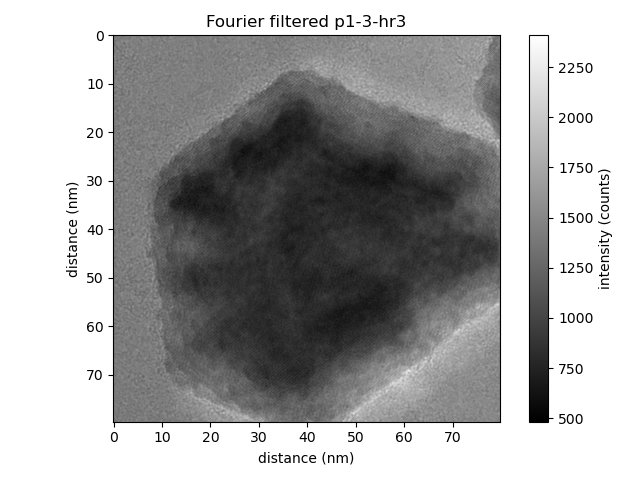

In [14]:
filtered_dataset = pyTEMlib.image_tools.adaptive_fourier_filter(image, spots, 
                                                                low_pass=2.0, reflection_radius=.3)
view = filtered_dataset.plot(cmap='gray')

Let's see what we did - In Fourier space, of course.

fft :
	smoothing : 1
	minimum_intensity : 10.122878251923055
	maximum_intensity : 17.86281328568153
source:  p1-3-hr3


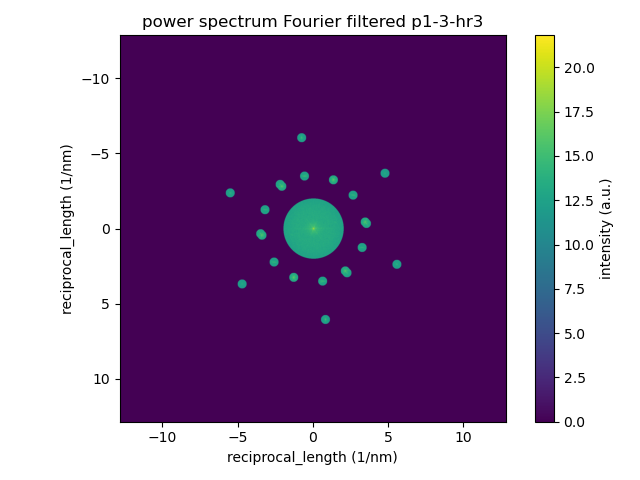

In [16]:
filtered_power_spectrum = pyTEMlib.image_tools.power_spectrum(filtered_dataset, smoothing=0)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = filtered_power_spectrum.plot()

Please note that the spots are ordered from center to outside.

The third parameter of a spot is its angle.

In [17]:
print(spots[:5])

[[-2.62027028  2.21908057 -0.86811058]
 [ 2.62027028 -2.21908057  2.27348207]
 [-3.4226497   0.43880124 -1.44328677]
 [ 3.4226497  -0.43880124  1.69830589]
 [-3.22205484 -1.25371784 -1.94187537]]


## Log the result

In [18]:
filtered_dataset.title = 'Fourier_Filtered_Image'
datasets.update({'Log_000': filtered_dataset})

### Save Datasets to file

In [ ]:
group = pyTEMlib.file_tools.save_dataset(datasets, filename=dataset.metadata['filename'])

A convenient function to select a dataset (for further processing, visualization or whatever)

In [13]:
chooser = pyTEMlib.file_tools.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: p1-3-hr3', 'Log_000: Fourier_Filtered_Image'), …

In [14]:
chooser.dataset.metadata

{'analysis': 'adaptive fourier filtered',
 'spots': array([[-2.62027028,  2.21908057, -0.86811058],
        [ 2.62027028, -2.21908057,  2.27348207],
        [-3.4226497 ,  0.43880124, -1.44328677],
        [ 3.4226497 , -0.43880124,  1.69830589],
        [-3.22205484, -1.25371784, -1.94187537],
        [ 3.22205484,  1.25371784,  1.19971728],
        [ 1.31640373, -3.23459202,  2.75508635],
        [-1.31640373,  3.23459202, -0.38650631],
        [-2.10624597, -2.80832796, -2.49809154],
        [ 2.10624597,  2.80832796,  0.64350111],
        [-3.51040995,  0.33850382, -1.47466498],
        [ 3.51040995, -0.33850382,  1.66692768],
        [-0.60178456, -3.48533559, -2.97061654],
        [ 0.60178456,  3.48533559,  0.17097612],
        [-2.21908057, -2.93369974, -2.49400159],
        [ 2.21908057,  2.93369974,  0.64759107],
        [-4.73905343,  3.67339327, -0.91140362],
        [ 4.73905343, -3.67339327,  2.23018903],
        [-5.52889567, -2.36952671, -1.97568811],
        [ 5.528895

A tree-like plot of the file

In [15]:
print(dataset.h5_dataset.file.filename)
pyTEMlib.file_tools.h5_tree(dataset.h5_dataset.file)

C:\Users\gduscher\Documents\Github\pyTEMlib\example_data\p1-3-hr3-1.hf5
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ p1_3_hr3
      --------
      ├ metadata
        --------
        ├ experiment
          ----------
      ├ original_metadata
        -----------------
        ├ DM
          --
        ├ DocumentObjectList
          ------------------
          ├ 0
            -
            ├ AnnotationGroupList
              -------------------
              ├ 0
                -
                ├ Font
                  ----
                ├ ObjectTags
                  ----------
            ├ ImageDisplayInfo
              ----------------
              ├ DimensionLabels
                ---------------
              ├ MainSliceId
                -----------
            ├ ObjectTags
              ----------
        ├ DocumentTags
          ------------
        ├ Image Behavior
          --------------
          ├ UnscaledTransform
            ----------

## Close File
let's close the file but keep the filename

In [16]:
filename = dataset.h5_dataset.file.filename
dataset.h5_dataset.file.close()

## Simulate new notebook
We can now simulate a new notebook and open the file again.



In [17]:
new_dataset= pyTEMlib.file_tools.open_file(filename)
choose_image = pyTEMlib.file_tools.ChooseDataset(new_dataset)

Dropdown(description='select dataset:', options=('Channel_000: p1_3_hr3', 'Log_000: Fourier_Filtered_Image'), …

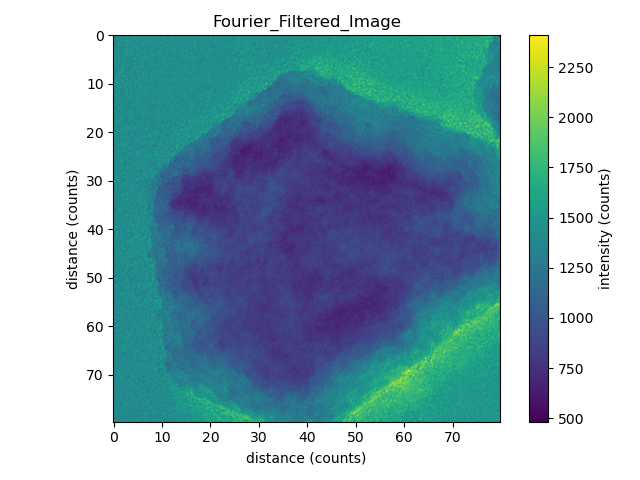

In [18]:
view = choose_image.dataset.plot()

We want to make an image operation of the images in the file.

In [19]:
choose_image = pyTEMlib.file_tools.ChooseDataset(new_dataset)
print('       subtract')
choose_image2 = pyTEMlib.file_tools.ChooseDataset(new_dataset)

Dropdown(description='select dataset:', options=('Channel_000: p1_3_hr3', 'Log_000: Fourier_Filtered_Image'), …

       subtract


Dropdown(description='select dataset:', options=('Channel_000: p1_3_hr3', 'Log_000: Fourier_Filtered_Image'), …

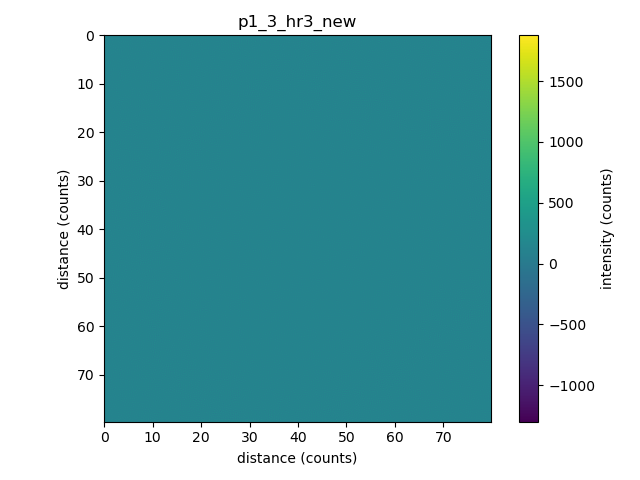

In [20]:
new_image = np.array(choose_image.dataset) - np.array(choose_image2.dataset)
new_image = choose_image.dataset.like_data(new_image)
vew = new_image.plot()

In [21]:
choose_image.dataset.metadata

{'filename': 'C:\\Users\\gduscher\\Documents\\Github\\pyTEMlib\\example_data\\p1-3-hr3.dm3',
 'experiment': {'acceleration_voltage': 199990.28125,
  'exposure_time': 1.0,
  'microscope': 'Libra 200 MC'}}